In [2]:
from pandas.io import sql
from sqlalchemy import create_engine, inspect

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv("gather_data.csv")
df = data.iloc[:, 1:]
df['City'] = [x.strip() for x in df['City']]
df['City'] = df['City'].astype('category')

In [5]:
df.head()
df.columns

Index(['MLSNumber', 'Street', 'City', 'Price', 'BR', 'Bath', 'Footage',
       'PricePerSqft', 'Zipcode'],
      dtype='object')

## Classifiers

In [6]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')

In [7]:
def fitClassifiers(df, x_list, y, classifiers, classifierNames):
    overall_max = [list(x_list)[0], classifierNames[0], 0]
    for x in x_list:
        X = df[list(x)]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
        print(list(x))
        local_max = [list(x), classifierNames[0], 0]
        for name, classifier in zip(classifierNames, classifiers):
            classifier.fit(X_train, y_train)
            score = classifier.score(X_test, y_test)
            if score > local_max[2]:
                local_max = [list(x), name, score]
        print(local_max)
        if local_max[2] > overall_max[2]:
            overall_max = local_max
    print("Best is: " , overall_max)
    
    return zip(classifiers, classifierNames)

## Predicting City From Other Features

In [8]:
y = df[['City']]
x_vars = ['Price', 'BR', 'Bath', 'Footage', 'PricePerSqft']

# get power set
import itertools
x_list = list(itertools.chain.from_iterable(itertools.combinations(x_vars,n) for n in range(1, len(x_vars)+1)))

cityClassifiers = [
    KNeighborsClassifier(len(df['City'].unique())),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_features='log2', max_depth=len(df['City'].unique())),
    RandomForestClassifier(n_estimators=len(df['City'].unique()), max_depth=10),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()
]

cityClassifiersName = [
    "KNN",
    "SVM",
    "Decision Tree",
    "Random Forest",
    "Multi-layer Perception",
    "Ada Boost",
    "Gaussian"
]

fitClassifiers(df, x_list, y, cityClassifiers, cityClassifiersName)

['Price']
[['Price'], 'KNN', 0.22362869198312235]
['BR']
[['BR'], 'Multi-layer Perception', 0.18565400843881857]
['Bath']
[['Bath'], 'SVM', 0.18143459915611815]
['Footage']
[['Footage'], 'SVM', 0.2109704641350211]
['PricePerSqft']
[['PricePerSqft'], 'KNN', 0.24472573839662448]
['Price', 'BR']
[['Price', 'BR'], 'KNN', 0.22362869198312235]
['Price', 'Bath']
[['Price', 'Bath'], 'KNN', 0.21940928270042195]
['Price', 'Footage']
[['Price', 'Footage'], 'Random Forest', 0.27426160337552741]
['Price', 'PricePerSqft']
[['Price', 'PricePerSqft'], 'Gaussian', 0.23628691983122363]
['BR', 'Bath']
[['BR', 'Bath'], 'SVM', 0.189873417721519]
['BR', 'Footage']
[['BR', 'Footage'], 'SVM', 0.189873417721519]
['BR', 'PricePerSqft']
[['BR', 'PricePerSqft'], 'KNN', 0.24472573839662448]
['Bath', 'Footage']
[['Bath', 'Footage'], 'SVM', 0.19831223628691982]
['Bath', 'PricePerSqft']
[['Bath', 'PricePerSqft'], 'KNN', 0.24472573839662448]
['Footage', 'PricePerSqft']
[['Footage', 'PricePerSqft'], 'Random Forest', 0.

## Predicting Price Segment Based on Other Features

In [9]:
price = df['Price']

In [10]:
price.describe()

count    1.185000e+03
mean     6.299467e+05
std      5.632996e+05
min      2.800000e+04
25%      3.500000e+05
50%      4.950000e+05
75%      7.550000e+05
max      8.250000e+06
Name: Price, dtype: float64

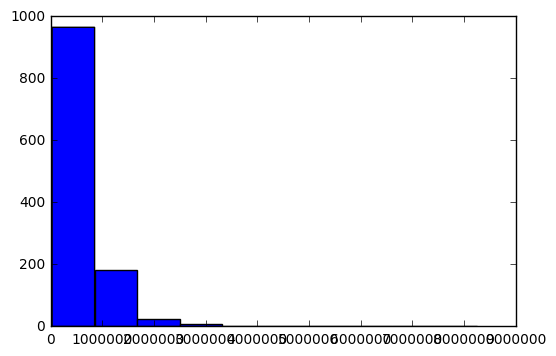

In [11]:
plt.hist(bins=10, x=df['Price'])
plt.show()

### Splitting into 5 groups
    1. 0 - 199,999
    2. 200,000 - 399,999
    3. 400,000 - 599,999
    4. 600,000 - 799,999
    5. 800,000 and Above

In [12]:
def getPriceCategory(numBins):   
    labs = [('%d00K and under' % x) for x in range(1,numBins+1)]
    labs.append("1 Mil and above")
    binCutOffs = [x for x in range(0,1000001, int(1000000/numBins))]
    binCutOffs.append(1000000000)
    return pd.cut(df['Price'], 
           bins = binCutOffs,
           labels=labs)

In [13]:
price_cat = getPriceCategory(10)

In [14]:
dummies = pd.get_dummies(df['City'], prefix="City")

In [15]:
cityDf = df[['BR', 'Bath', 'PricePerSqft']]

In [16]:
cityDf = pd.concat([cityDf, dummies], axis = 1)

In [17]:
y = price_cat
#x_vars = ['BR', 'Bath', 'PricePerSqft']
x_list = [list(cityDf.columns)]
import itertools
#x_list = list(itertools.chain.from_iterable(itertools.combinations(x_vars,n) for n in range(1, len(x_vars)+1)))

cityClassifiers = [
    KNeighborsClassifier(len(df['City'].unique())),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_features='log2', max_depth=10),
    RandomForestClassifier(n_estimators=10, max_depth=10),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()
]

cityClassifiersName = [
    "KNN",
    "SVM",
    "Decision Tree",
    "Random Forest",
    "Multi-layer Perception",
    "Ada Boost",
    "Gaussian"
]

fitClassifiers(cityDf, x_list, y, cityClassifiers, cityClassifiersName)

['BR', 'Bath', 'PricePerSqft', 'City_Arroyo Grande', 'City_Atascadero', 'City_Avila Beach', 'City_Bakersfield', 'City_Ballard', 'City_Bradley', 'City_Buellton', 'City_Cambria', 'City_Cayucos', 'City_Clovis', 'City_Coalinga', 'City_Creston', 'City_Fresno', 'City_Goleta', 'City_Greenfield', 'City_Grover Beach', 'City_Guadalupe', 'City_Hanford', 'City_King City', 'City_Lompoc', 'City_Los Alamos', 'City_Los Olivos', 'City_Los Osos', 'City_Morro Bay', 'City_Nipomo', 'City_Oceano', 'City_Paso Robles', 'City_Pismo Beach', 'City_Porterville', 'City_Salinas', 'City_San Luis Obispo', 'City_San Miguel', 'City_San Simeon', 'City_Santa Barbara', 'City_Santa Margarita', 'City_Santa Maria', 'City_Santa Ynez', 'City_Shandon', 'City_Solvang', 'City_Tehachapi', 'City_Templeton', 'City_Visalia', 'City_Wasco']
[['BR', 'Bath', 'PricePerSqft', 'City_Arroyo Grande', 'City_Atascadero', 'City_Avila Beach', 'City_Bakersfield', 'City_Ballard', 'City_Bradley', 'City_Buellton', 'City_Cambria', 'City_Cayucos', 'Cit

## Predict Zipcode

In [18]:
y = df[['Zipcode']]
x_vars = ['BR', 'Bath', 'Footage', 'Price', 'PricePerSqft']

import itertools
x_list = list(itertools.chain.from_iterable(itertools.combinations(x_vars,n) for n in range(1, len(x_vars)+1)))

cityClassifiers = [
    KNeighborsClassifier(len(df['Zipcode'].unique())),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_features='log2', max_depth=10),
    RandomForestClassifier(n_estimators=10, max_depth=10),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()
]

cityClassifiersName = [
    "KNN",
    "SVM",
    "Decision Tree",
    "Random Forest",
    "Multi-layer Perception",
    "Ada Boost",
    "Gaussian"
]

fitClasses = fitClassifiers(df, x_list, y, cityClassifiers, cityClassifiersName)

['BR']
[['BR'], 'Multi-layer Perception', 0.11392405063291139]
['Bath']
[['Bath'], 'KNN', 0.13080168776371309]
['Footage']
[['Footage'], 'SVM', 0.14767932489451477]
['Price']
[['Price'], 'KNN', 0.13502109704641349]
['PricePerSqft']
[['PricePerSqft'], 'KNN', 0.16455696202531644]
['BR', 'Bath']
[['BR', 'Bath'], 'Decision Tree', 0.14767932489451477]
['BR', 'Footage']
[['BR', 'Footage'], 'SVM', 0.14345991561181434]
['BR', 'Price']
[['BR', 'Price'], 'Random Forest', 0.15611814345991562]
['BR', 'PricePerSqft']
[['BR', 'PricePerSqft'], 'KNN', 0.16455696202531644]
['Bath', 'Footage']
[['Bath', 'Footage'], 'SVM', 0.14345991561181434]
['Bath', 'Price']
[['Bath', 'Price'], 'KNN', 0.13924050632911392]
['Bath', 'PricePerSqft']
[['Bath', 'PricePerSqft'], 'KNN', 0.16455696202531644]
['Footage', 'Price']
[['Footage', 'Price'], 'Random Forest', 0.189873417721519]
['Footage', 'PricePerSqft']
[['Footage', 'PricePerSqft'], 'Decision Tree', 0.14767932489451477]
['Price', 'PricePerSqft']
[['Price', 'PricePe

In [19]:
fitClasses = list(fitClasses)

In [20]:
# have a list of classifiers we will use
# write model functions that will return score of model and the error, and computation time
# Logistic Regression - multiclass
# kNN
# AdaBoostClassifier
# Random Forest
# DecisionTreeClassifier
# SVM
# ensemble
    # Voting
    # Bagging
    # Boosting

# Voting

In [21]:
from sklearn.ensemble import VotingClassifier

In [ ]:
y = df[['Zipcode']]
x_vars = ['BR', 'Bath', 'Footage', 'Price', 'PricePerSqft']

import itertools
x_list = list(itertools.chain.from_iterable(itertools.combinations(x_vars,n) for n in range(1, len(x_vars)+1)))


cityClassifiers = [
    KNeighborsClassifier(len(df['Zipcode'].unique())),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_features='log2', max_depth=10),
    RandomForestClassifier(n_estimators=10, max_depth=10),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()
]

cityClassifiersName = [
    "KNN",
    "SVM",
    "Decision Tree",
    "Random Forest",
    "Multi-layer Perception",
    "Ada Boost",
    "Gaussian"
]

voter = VotingClassifier(list(zip(cityClassifiersName, cityClassifiers)), voting="hard")

In [ ]:
fitClassifiers(df, x_list, y, [voter], ["voter"])

['BR']
[['BR'], 'voter', 0.10548523206751055]
['Bath']
[['Bath'], 'voter', 0.11814345991561181]
['Footage']
[['Footage'], 'voter', 0.080168776371308023]
['Price']
[['Price'], 'voter', 0.11814345991561181]
['PricePerSqft']
[['PricePerSqft'], 'voter', 0.16455696202531644]
['BR', 'Bath']
[['BR', 'Bath'], 'voter', 0.12658227848101267]
['BR', 'Footage']
[['BR', 'Footage'], 'voter', 0.10126582278481013]
['BR', 'Price']
[['BR', 'Price'], 'voter', 0.16033755274261605]
['BR', 'PricePerSqft']
[['BR', 'PricePerSqft'], 'voter', 0.1729957805907173]
['Bath', 'Footage']
[['Bath', 'Footage'], 'voter', 0.11392405063291139]
['Bath', 'Price']
[['Bath', 'Price'], 'voter', 0.12236286919831224]
['Bath', 'PricePerSqft']
[['Bath', 'PricePerSqft'], 'voter', 0.13080168776371309]
['Footage', 'Price']


From this we see that voting does not outperform the individual best performance of the classifiers.